In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
import graphviz
from sklearn.preprocessing import OneHotEncoder

In [46]:
class Node:
    def __init__(self,
                 node_id,
                 split_criterion,
                 true_branch,
                 false_branch,
                 depth,
                 gain,
                 data):
        self.node_id = node_id
        self.split_criterion = split_criterion
        self.true_branch = true_branch
        self.false_branch = false_branch
        self.depth = depth
        self.gain = gain
        self.data = data

In [152]:
class DT: 
    def __init__(self,
                 mode,
                 data,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 max_depth=None):
        self.data = data
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.depth = 0
        self.nodes = []
        self.base_node_id = 0
        self.mode = mode

    def gini(self, data):
        if data.shape[0] == 0: 
            return 0
        counts = class_counts(data)
        val = np.array(list(counts.values()))
        portions = val / len(data)
        return 1 - np.sum(portions**2)
    
    def mse(self, data): 
        y = data.iloc[:, -1]
        avg_pred = np.mean(y)
        
        return np.sum((y - avg_pred)**2)
    
    def cost(self, data): 
        if self.mode == 'classification':
            return self.gini(data)
        else: 
            return self.mse(data)
    
    
    def info_gain(self, true_rows, false_rows, current_cost):
        p = round(len(true_rows) / (len(true_rows) + len(false_rows)), 3)
        return current_cost - p * self.cost(true_rows) - (1 - p) * self.cost(false_rows)
    
    def partition(self, data, feature, val):
        total_rows= data.shape[0]
        
        if data.dtypes[feature] == 'O':
            condition =  data.iloc[:, feature] == val
        else: 
            condition =  data.iloc[:, feature] >= val
        
        true_idx = np.argwhere(condition.values).ravel()
        false_idx = np.setxor1d(np.arange(total_rows), true_idx)
        
        return  data.iloc[true_idx,:], data.iloc[false_idx,:]
    
    def find_split(self, data):
        best_gain = 0
        current_cost = self.cost(data)
        num_features = data.shape[1] - 1

        for n_f in range(num_features):
            unique_vals = np.unique(data.iloc[:, n_f])
            for uniq_val in unique_vals:
                filter_criteria = {'feature': n_f, 'value': uniq_val}

                true_rows, false_rows = self.partition(data, n_f, uniq_val)

                gain = self.info_gain(true_rows, false_rows, current_cost)
                if gain >= best_gain:
                    best_gain, best_filter = gain, filter_criteria
        
        return best_gain, best_filter
    
    def counter(self):
        self.base_node_id += 1
        return self.base_node_id
    
    def grow_tree(self, data, node_id):
        best_gain, best_filter = self.find_split(data)

        true_rows, false_rows = self.partition(data, best_filter['feature'], best_filter['value'])    
        num_samples = len(true_rows) + len(false_rows)
        
        is_leaf = (best_gain == 0 or num_samples <= self.min_samples_leaf) or \
                  (self.max_depth is None and self.depth <= self.max_depth)
        
        if is_leaf : 
            self.nodes.append(Node(node_id, best_filter, None, None, self.depth, best_gain, data))
        else:
            right_node_id = self.counter()
            left_node_id = self.counter()

            self.nodes.append(Node(node_id, best_filter, right_node_id, left_node_id, self.depth, best_gain, data))

            self.depth = self.depth + 1
            self.grow_tree(true_rows, right_node_id)
            self.grow_tree(false_rows, left_node_id)        

    def fit(self):
        node_id = self.counter()
        return self.grow_tree(self.data, node_id)
    
    
    def leaf_pred(self, data, node):
        if self.mode == 'classification':
            cc = class_counts(node.data)
            cc_val = np.array(list(cc.values()))

            cc_name = np.array(list(cc.keys()))
            sum_cc_val = np.sum(cc_val)

            pz = np.zeros(len(class_names))
            for i in range(len(cc_name)): 
                c_idx = np.argwhere(cc_name[i] == class_names)[0][0]
                pz[i] = cc_val[i] / sum_cc_val

            return pz
        else: 
            return np.mean(node.data.iloc[:,-1])
            
    
    def predict(self, data, node_id=1):
        node = self.find_node(node_id)

        if not node.true_branch:      
            return self.leaf_pred(data, node)

        is_true = self.is_condition_true(node.split_criterion, data)

        if (is_true):
            next_node = node.true_branch
        else:
            next_node = node.false_branch

        return self.predict(data, next_node)

    def draw(self):
        dot = graphviz.Digraph()
        
        for i in range(len(self.nodes)):
            if self.nodes[i].true_branch: 
                dot.node(str(self.nodes[i].node_id), self.get_criteria_strig(self.nodes[i].split_criterion))
            else: 
                if self.mode == 'classification':
                    dot.node(str(self.nodes[i].node_id), str(class_counts(self.nodes[i].data)))
                else: 
                    dot.node(str(self.nodes[i].node_id), str(np.mean(self.nodes[i].data.iloc[:, -1])))
        edges = []
        for i in range(len(self.nodes)):
            node_id = str(self.nodes[i].node_id)
            right_node_id = str(self.nodes[i].true_branch)
            left_node_id = str(self.nodes[i].false_branch)
            
            if right_node_id != 'None':
                dot.edge(node_id, right_node_id, label='TRUE')
                dot.edge(node_id, left_node_id, label='FALSE')
        
        return dot
    def find_node(self, node_id):
        for i in range(len(self.nodes)):
            if node_id == self.nodes[i].node_id:
                return self.nodes[i]  
            
    def get_criteria_strig(self, split_criterion):
        symbol = '==' if self.data.dtypes[split_criterion['feature']] == 'O' else '>='
        return 'X[{}] {} {}'.format(split_criterion['feature'], symbol, split_criterion['value'])
    
    def is_condition_true(self, split_criterion, data): 
        if self.data.dtypes[split_criterion['feature']] == 'O':
            condition_val = data[split_criterion['feature']] == split_criterion['value']
        else: 
            condition_val = data[split_criterion['feature']] >= split_criterion['value']
        return condition_val

In [153]:
def class_counts(data):
    class_idx = 2
    res = {}
    for c_name in class_names: 
        count = np.sum(data['label'] == c_name)
        res[c_name] = count
    return res

### Regression

In [154]:
training_data_reg = pd.DataFrame([
    ['Green', 3, 0.7],
    ['Green', 1, 0.2],
    ['Red', 1, 0.5],
    ['Red', 4, 0.1],
    ['Yellow', 4, 0.6],
], columns=['color', 'size', 'label'] )

data_reg = training_data_reg.iloc[:, 0:-1]
labels_reg = training_data_reg.iloc[:, -1]
n = pd.get_dummies(data_reg.iloc[:,0])
data_reg = data_reg.drop(columns=['color'])
train_data_reg = pd.concat([n, data_reg], axis=1)

In [155]:
new_data_reg = pd.concat([train_data_reg, labels_reg], axis=1)

In [156]:
dt = DT(mode='regression', data=new_data_reg, max_depth=3)
dt.fit()

In [157]:
dt.predict(new_data_reg.iloc[0])

0.7

In [158]:
dot = dt.draw()

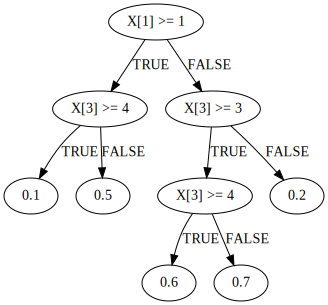

In [159]:
dot

### Classification

In [161]:
training_data_cl = pd.DataFrame([
    ['Green', 3, 'Apple'],
    ['Yellow', 3, 'Apple'],
    ['Red', 1, 'Grape'],
    ['Red', 1, 'Grape'],
    ['Yellow', 3, 'Lemon'],
], columns=['color', 'size', 'label'] )

In [162]:
class_names = training_data_cl.iloc[:, 2].unique()

In [163]:
data_cl = training_data_cl.iloc[:, 0:-1]
labels_cl = training_data_cl.iloc[:, -1]

In [164]:
n_cl = pd.get_dummies(data_cl.iloc[:,0])

In [165]:
data_cl = data_cl.drop(columns=['color'])
train_data_cl = pd.concat([n_cl, data_cl], axis=1)

In [166]:
new_data_cl = pd.concat([train_data_cl, labels_cl], axis=1)

In [167]:
dt_cl = DT(mode='classification', data=new_data_cl, max_depth=3)
dt_cl.fit()

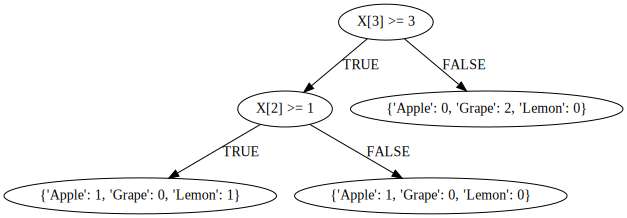

In [168]:
dt_cl.draw()